In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
!export CUDA_VISIBLE_DEVICES=3
os.environ['TRANSFORMERS_CACHE'] = '../../../hfcache'
!export TRANSFORMERS_CACHE='../../../hfcache'
cache_dir = "../../../hfcache"
device = 'cuda'

# Данные

In [4]:
# Чтение файла CSV
data = pd.read_csv('train_spam.csv')

# Таргет переводим в вид 0 - не спам, 1 - спам
target_dict = {'ham': 0, 'spam' : 1}
data['text_type'] = data['text_type'].apply(lambda x: target_dict[x])

<Axes: >

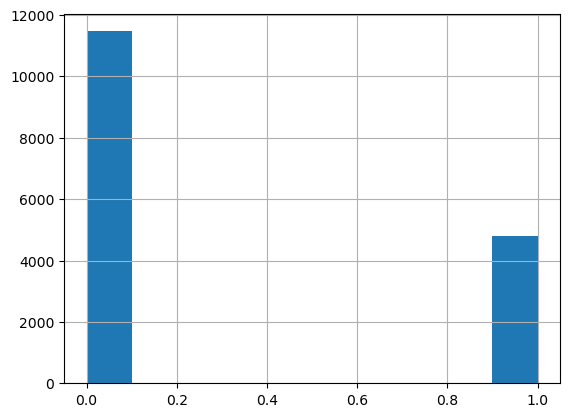

In [34]:
data['text_type'].hist()

Очевиден дисбалланс классов, можно взять данные из открытых датасетов, чтобы уравнять количество примеров для каждого из классов, но в этой задаче это не критично

In [7]:
stops = stopwords.words('english')

stemmer = PorterStemmer()
# Лемматизация показала себя хуже, поэтому остановился на стэмминге
data['text'] = data['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))

# Разделение выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['text_type'], test_size=0.2, random_state=42)

In [8]:
# Векторизация текстов с помощью счетчика (TF-IDF векторизация была не лучше)
tfidf_vectorizer = CountVectorizer(min_df=3, ngram_range=(1,3), stop_words=stopwords.words('english'))

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Модели

### Наивный байесовский классификатор

Это самое базовое, что можно обучать для классификации текстов, иногда срабатывает очень хорошо

In [9]:
# Обучение наивного байесовского классификатора
nb_classifier = BernoulliNB()
nb_classifier.fit(X_train_tfidf, y_train)

BernoulliNB()

Если смотреть на отношение качества к затраченным ресурсам, то результат хороший

In [10]:
# Оценка точности наивного байесовского классификатора
nb_prediction = nb_classifier.predict(X_test_tfidf)
print(classification_report(nb_prediction, y_test, target_names=['not spam', 'spam']))
print('ROC-AUC: ', roc_auc_score(nb_prediction, y_test))

              precision    recall  f1-score   support

    not spam       0.98      0.94      0.96      2421
        spam       0.85      0.95      0.89       835

    accuracy                           0.94      3256
   macro avg       0.91      0.94      0.93      3256
weighted avg       0.95      0.94      0.94      3256

ROC-AUC:  0.9447182462831463


### Логистическая регрессия

Данные разреженные + большая размерность, значит логистическая регрессия должна показать себя хорошо

In [11]:
lr_classifier = LogisticRegression(max_iter=500)
lr_classifier.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=500)

**80% результата за 20% времени мы уже получили**

In [12]:
# Оценка точности логистической регрессии
lr_prediction = lr_classifier.predict(X_test_tfidf)
print(classification_report(lr_prediction, y_test, target_names=['not spam', 'spam']))
print('ROC-AUC: ',roc_auc_score(lr_prediction, y_test))

              precision    recall  f1-score   support

    not spam       0.98      0.95      0.96      2385
        spam       0.87      0.94      0.91       871

    accuracy                           0.95      3256
   macro avg       0.93      0.95      0.93      3256
weighted avg       0.95      0.95      0.95      3256

ROC-AUC:  0.945046899031692


### Получение эмбеддингов в виде первой матрицы SVD-разложения 

Получим эмбеддинг для каждого из текстов, с помощью SVD-разложения (оставляем первую матрицу в разложении, строки - векторы для каждого текста)

In [13]:
# Применение метода главных компонент (PCA) к векторизованным текстам
pca = TruncatedSVD(n_components=64)
X_train_pca = pca.fit_transform(X_train_tfidf)
X_test_pca = pca.transform(X_test_tfidf)

### Еще раз обучим логистическую регрессию

In [14]:
lr_classifier_pca = LogisticRegression(max_iter=500)
lr_classifier_pca.fit(X_train_pca, y_train)

LogisticRegression(max_iter=500)

In [15]:
# Оценка точности после применения PCA
lr_prediction_pca = lr_classifier_pca.predict(X_test_pca)
print(classification_report(lr_prediction_pca, y_test, target_names=['not spam', 'spam']))
print(roc_auc_score(lr_prediction_pca, y_test))

              precision    recall  f1-score   support

    not spam       0.96      0.87      0.92      2561
        spam       0.65      0.88      0.75       695

    accuracy                           0.87      3256
   macro avg       0.81      0.88      0.83      3256
weighted avg       0.90      0.87      0.88      3256

0.8763118049098402


### Попробуем обучить случайный лес

In [16]:
rf = RandomForestClassifier(n_estimators=500, max_features='sqrt')
rf.fit(X_train_pca, y_train)

RandomForestClassifier(n_estimators=500)

In [17]:
rf_prediction_pca = rf.predict(X_test_pca)
print(classification_report(rf_prediction_pca, y_test, target_names=['not spam', 'spam']))
print(roc_auc_score(rf_prediction_pca, y_test))

              precision    recall  f1-score   support

    not spam       0.97      0.92      0.94      2456
        spam       0.79      0.92      0.85       800

    accuracy                           0.92      3256
   macro avg       0.88      0.92      0.90      3256
weighted avg       0.93      0.92      0.92      3256

0.9178298045602606


**Извлечение эмбеддингов на классических моделях ничего не дало. Лучше всего отработала лог. регрессия (даже при минимальной предобработке тексов уже выдает приемлимый результат)**

# Двунаправленная LSTM модель

**Строго говоря, лучше было бы получить эмбеддинги для каждого токена с помощью pmi матрицы и уже после этого обучать нейросеть, но в этой задаче такой необходимости нет**

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader
import pandas as pd

**Отфильтруем слова по частоте и добавим оставшиеся в наш словарь (стэмминг оставим, чтобы снизить количество токенов в словаре)**

In [19]:
from collections import Counter
texts = list(X_train)
cnt = Counter()

for text in texts:
    cnt.update(text.split())

In [20]:
tok2ind = {'<PAD>':0, '<UNK>':1}
min_count = 3

idx = 2
for token in cnt.keys():
    if cnt[token] >= min_count:
        tok2ind[token] = idx
        idx += 1

In [21]:
def tokenize(txt):
    result = txt.split()
    for idx in range(len(result)):
        result[idx] = tok2ind.get(result[idx], 1)
    return result

In [22]:
# Создание датасета для хранения сообщений и меток спам/не спам
class SpamDataset(Dataset):
    def __init__(self, texts, target, is_test=False):
        self.texts = texts
        self.target = target
        self.is_test = is_test

        for idx in range(len(self.texts)):
            self.texts[idx] = tokenize(self.texts[idx])
            
    def __len__(self):
        return len(self.texts)

    
    def __getitem__(self, idx):
        if self.is_test:
            return self.texts[idx]
            
        return self.texts[idx], self.target[idx]

# Функция для dataloader'а
def pad_sequence(data):
    sequences = [elem[0] for elem in data]
    targets = [elem[1] for elem in data]
    max_len = max([len(elem) for elem in sequences])
    padded_sequences = [None for _ in range(len(sequences))]
    for idx, sequence in enumerate(sequences):
        padded_sequences[idx] = sequence + [tok2ind['<PAD>']] * (max_len - len(sequence))
        
    return torch.tensor(padded_sequences), torch.tensor(targets)

In [23]:
batch_size = 256

train_dataset = SpamDataset(list(X_train), list(y_train))
test_dataset = SpamDataset(list(X_test), list(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=pad_sequence, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=pad_sequence, shuffle=False)

In [29]:
# Двунаправленная LSTM модель с головой для классификации спам/не спам
class BiLSTMClassifier(nn.Module):
    def __init__(self, hidden_size=150, num_layers=2, num_classes=2, dropout=0.12):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        # Количество слоев в lstm слое
        self.num_layers = num_layers
        self.embedding = nn.Embedding(len(tok2ind), hidden_size)
        # Если добавить еще слой, то и dropout можно добавить в lstm 
        self.bilstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        # Чтобы не переобучалась
        self.dropout2 = nn.Dropout(dropout)
        # Чтобы линейный слой лучше срабатывал
        self.norm2 = nn.LayerNorm(2 * hidden_size)
        # Голова для классификации
        self.fc = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.bilstm(embeds)
        out = self.fc(self.dropout2(self.norm2(lstm_out.sum(dim=1)))) 
        return out


In [30]:
from adan_pytorch import Adan

In [31]:
model = BiLSTMClassifier()
criterion = nn.CrossEntropyLoss()
# Выбрал Adan, потому что для этой модели дополнительной памяти будет выделяться немного, а learning rate можно повысить
optimizer = Adan(model.parameters(), lr = 1e-3, betas = (0.9, 0.9, 0.9), weight_decay = 0.002)
# scheduler выбрал стандартный, с ним лучше, чем без него
scheduler = ExponentialLR(optimizer, gamma=0.89)

model = model.to(device)

In [32]:
from tqdm import tqdm
import gc

In [33]:
num_epochs=20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, target in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        target = target.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_train_loss = total_loss / len(train_loader)
    scheduler.step()
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        corr = []
        pred = []
        for inputs, target in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu()
            corr += target
            pred += predicted
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    roc = roc_auc_score(corr, pred)
    accuracy = correct / total
    gc.collect()
    torch.cuda.empty_cache()
    print(classification_report(corr, pred, target_names=['not spam', 'spam']))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_train_loss:.4f}, Accuracy: {accuracy:.4f}, roc-auc: {roc:.4f}')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.49it/s]


              precision    recall  f1-score   support

    not spam       0.85      0.91      0.88      2321
        spam       0.73      0.61      0.66       935

    accuracy                           0.82      3256
   macro avg       0.79      0.76      0.77      3256
weighted avg       0.82      0.82      0.82      3256

Epoch [1/20], Loss: 0.6248, Accuracy: 0.8225, roc-auc: 0.7599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.50it/s]


              precision    recall  f1-score   support

    not spam       0.89      0.98      0.93      2321
        spam       0.92      0.69      0.79       935

    accuracy                           0.89      3256
   macro avg       0.90      0.83      0.86      3256
weighted avg       0.90      0.89      0.89      3256

Epoch [2/20], Loss: 0.3575, Accuracy: 0.8928, roc-auc: 0.8316


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.16it/s]


              precision    recall  f1-score   support

    not spam       0.93      0.96      0.95      2321
        spam       0.90      0.83      0.86       935

    accuracy                           0.92      3256
   macro avg       0.91      0.89      0.90      3256
weighted avg       0.92      0.92      0.92      3256

Epoch [3/20], Loss: 0.2321, Accuracy: 0.9223, roc-auc: 0.8934


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.17it/s]


              precision    recall  f1-score   support

    not spam       0.96      0.93      0.95      2321
        spam       0.84      0.91      0.87       935

    accuracy                           0.92      3256
   macro avg       0.90      0.92      0.91      3256
weighted avg       0.93      0.92      0.92      3256

Epoch [4/20], Loss: 0.1774, Accuracy: 0.9235, roc-auc: 0.9199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.23it/s]


              precision    recall  f1-score   support

    not spam       0.95      0.97      0.96      2321
        spam       0.91      0.88      0.89       935

    accuracy                           0.94      3256
   macro avg       0.93      0.92      0.93      3256
weighted avg       0.94      0.94      0.94      3256

Epoch [5/20], Loss: 0.1413, Accuracy: 0.9404, roc-auc: 0.9212


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.33it/s]


              precision    recall  f1-score   support

    not spam       0.97      0.94      0.96      2321
        spam       0.87      0.92      0.89       935

    accuracy                           0.94      3256
   macro avg       0.92      0.93      0.92      3256
weighted avg       0.94      0.94      0.94      3256

Epoch [6/20], Loss: 0.1173, Accuracy: 0.9370, roc-auc: 0.9319


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.42it/s]


              precision    recall  f1-score   support

    not spam       0.96      0.96      0.96      2321
        spam       0.91      0.90      0.90       935

    accuracy                           0.94      3256
   macro avg       0.93      0.93      0.93      3256
weighted avg       0.94      0.94      0.94      3256

Epoch [7/20], Loss: 0.0985, Accuracy: 0.9447, roc-auc: 0.9306


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.48it/s]


              precision    recall  f1-score   support

    not spam       0.97      0.95      0.96      2321
        spam       0.87      0.94      0.90       935

    accuracy                           0.94      3256
   macro avg       0.92      0.94      0.93      3256
weighted avg       0.94      0.94      0.94      3256

Epoch [8/20], Loss: 0.0852, Accuracy: 0.9426, roc-auc: 0.9406


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.43it/s]


              precision    recall  f1-score   support

    not spam       0.96      0.98      0.97      2321
        spam       0.94      0.89      0.91       935

    accuracy                           0.95      3256
   macro avg       0.95      0.93      0.94      3256
weighted avg       0.95      0.95      0.95      3256

Epoch [9/20], Loss: 0.0721, Accuracy: 0.9521, roc-auc: 0.9329


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.34it/s]


              precision    recall  f1-score   support

    not spam       0.97      0.97      0.97      2321
        spam       0.92      0.92      0.92       935

    accuracy                           0.96      3256
   macro avg       0.95      0.95      0.95      3256
weighted avg       0.96      0.96      0.96      3256

Epoch [10/20], Loss: 0.0603, Accuracy: 0.9561, roc-auc: 0.9465


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.41it/s]


              precision    recall  f1-score   support

    not spam       0.97      0.97      0.97      2321
        spam       0.92      0.92      0.92       935

    accuracy                           0.95      3256
   macro avg       0.94      0.94      0.94      3256
weighted avg       0.95      0.95      0.95      3256

Epoch [11/20], Loss: 0.0528, Accuracy: 0.9539, roc-auc: 0.9434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.46it/s]


              precision    recall  f1-score   support

    not spam       0.97      0.95      0.96      2321
        spam       0.89      0.93      0.91       935

    accuracy                           0.95      3256
   macro avg       0.93      0.94      0.94      3256
weighted avg       0.95      0.95      0.95      3256

Epoch [12/20], Loss: 0.0475, Accuracy: 0.9487, roc-auc: 0.9442


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.18it/s]


              precision    recall  f1-score   support

    not spam       0.97      0.97      0.97      2321
        spam       0.93      0.92      0.92       935

    accuracy                           0.96      3256
   macro avg       0.95      0.95      0.95      3256
weighted avg       0.96      0.96      0.96      3256

Epoch [13/20], Loss: 0.0428, Accuracy: 0.9567, roc-auc: 0.9463


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.49it/s]


              precision    recall  f1-score   support

    not spam       0.97      0.96      0.97      2321
        spam       0.90      0.94      0.92       935

    accuracy                           0.95      3256
   macro avg       0.94      0.95      0.94      3256
weighted avg       0.95      0.95      0.95      3256

Epoch [14/20], Loss: 0.0377, Accuracy: 0.9530, roc-auc: 0.9485


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.70it/s]


              precision    recall  f1-score   support

    not spam       0.97      0.96      0.97      2321
        spam       0.91      0.93      0.92       935

    accuracy                           0.96      3256
   macro avg       0.94      0.95      0.95      3256
weighted avg       0.96      0.96      0.96      3256

Epoch [15/20], Loss: 0.0335, Accuracy: 0.9558, roc-auc: 0.9495


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.56it/s]


              precision    recall  f1-score   support

    not spam       0.96      0.97      0.97      2321
        spam       0.93      0.91      0.92       935

    accuracy                           0.95      3256
   macro avg       0.95      0.94      0.94      3256
weighted avg       0.95      0.95      0.95      3256

Epoch [16/20], Loss: 0.0295, Accuracy: 0.9545, roc-auc: 0.9413


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.54it/s]


              precision    recall  f1-score   support

    not spam       0.97      0.96      0.97      2321
        spam       0.90      0.94      0.92       935

    accuracy                           0.95      3256
   macro avg       0.94      0.95      0.94      3256
weighted avg       0.95      0.95      0.95      3256

Epoch [17/20], Loss: 0.0271, Accuracy: 0.9533, roc-auc: 0.9481


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.34it/s]


              precision    recall  f1-score   support

    not spam       0.97      0.96      0.97      2321
        spam       0.90      0.94      0.92       935

    accuracy                           0.95      3256
   macro avg       0.94      0.95      0.94      3256
weighted avg       0.95      0.95      0.95      3256

Epoch [18/20], Loss: 0.0261, Accuracy: 0.9521, roc-auc: 0.9482


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.57it/s]


              precision    recall  f1-score   support

    not spam       0.97      0.96      0.97      2321
        spam       0.91      0.93      0.92       935

    accuracy                           0.95      3256
   macro avg       0.94      0.94      0.94      3256
weighted avg       0.95      0.95      0.95      3256

Epoch [19/20], Loss: 0.0237, Accuracy: 0.9521, roc-auc: 0.9447


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.42it/s]


              precision    recall  f1-score   support

    not spam       0.97      0.96      0.97      2321
        spam       0.91      0.93      0.92       935

    accuracy                           0.95      3256
   macro avg       0.94      0.95      0.94      3256
weighted avg       0.95      0.95      0.95      3256

Epoch [20/20], Loss: 0.0233, Accuracy: 0.9539, roc-auc: 0.9460


Результаты лучше, чем у классических методов, однако, ресурсов на обучение и инференс требуется намного больше

# Предобученная модель

Модель, лучше всего показавшая себя, было решено ее не дообучать под наши данные, потому что результаты и так лучше всяких ожиданий

In [565]:
tokenizer = AutoTokenizer.from_pretrained("mshenoda/roberta-spam", device_map="auto", cache_dir=cache_dir)
model = AutoModelForSequenceClassification.from_pretrained("mshenoda/roberta-spam", device_map="auto", cache_dir=cache_dir)

In [566]:
from transformers import pipeline
model = model.to(device)
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [578]:
transformer_data = pd.read_csv('train_spam.csv')

target_dict = {'ham': 0, 'spam' : 1}
transformer_data['text_type'] = transformer_data['text_type'].apply(lambda x: target_dict[x])
transformer_text = transformer_data['text']
transformer_target = transformer_data['text_type']

Токенайзер у модели не очень оптимальный, поэтому приходится обрезать тексты

In [569]:
for i in range(len(transformer_text)):
    if len(transformer_text[i]) >= 175:
        transformer_text[i] = transformer_text[i][:175]

In [570]:
result_llm = pipe(list(transformer_text))

In [571]:
results = []
for idx in range(len(result_llm)):
    results.append(1 if result_llm[idx]['label'] == 'LABEL_1' else 0)

Тестировалась модель сразу на всей обучающей выборке, результаты превосходят все представленные ранее методы

In [579]:
print(classification_report(transformer_target, results, target_names=['not spam', 'spam']))
print('ROC-AUC: ',roc_auc_score(transformer_target, results))

              precision    recall  f1-score   support

    not spam       0.99      0.99      0.99     11469
        spam       0.98      0.97      0.98      4809

    accuracy                           0.99     16278
   macro avg       0.98      0.98      0.98     16278
weighted avg       0.99      0.99      0.99     16278

ROC-AUC:  0.9822079992463343


# Генерируем предсказания на тестововой выборке

In [581]:
transformer_test_data = pd.read_csv('test_spam.csv')
transformer_test_data.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [584]:
transformer_test_text = transformer_test_data['text']

for i in range(len(transformer_test_text)):
    if len(transformer_test_text[i]) >= 175:
        transformer_test_text[i] =  transformer_test_text[i][:175]

In [586]:
test_result_llm = pipe(list(transformer_test_text))

In [597]:
results_test = []
for idx in range(len(test_result_llm)):
    results_test.append(1 if test_result_llm[idx]['label'] == 'LABEL_1' else 0)

In [598]:
transformer_test_data['prediction'] = results_test

In [599]:
transformer_test_data.head()

,text,prediction
0,j jim whitehead ejw cse ucsc edu writes j you ...,0
1,original message from bitbitch magnesium net p...,0
2,java for managers vince durasoft who just taug...,0
3,there is a youtuber name saiman says,0
4,underpriced issue with high return on equity t...,1


In [609]:
transformer_test_data.to_csv('result.csv', index=False)